<a href="https://colab.research.google.com/github/teddius/TensorFlow_Chatbot_for_20171128_Talk_BotsHub_Meetup_Vienna/blob/master/text2speech_introduction_for_pvi_WS2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text2Speech Introduction for Programming Voice Interfaces WS2020
=====================================================================================================

Author: [Andreas Rath](https://github.com/teddius) - andreas.rath@ondewo.com

This example shows how to achieve speech recognition by using the library SpeechRecognition.


This lecture is based on tutorial and code from
* Google Text-to-Speech (gTTS) https://pypi.org/project/gTTS/ 
* Tutorial NVIDIA Text-to-Speech with Tacotron2 and Waveglow https://colab.research.google.com/github/tugstugi/dl-colab-notebooks/blob/master/notebooks/NVidia_Tacotron2_Waveglow.ipynb 

# Google Text-to-Speech (gTTS) 
gTTS (Google Text-to-Speech), a Python library and CLI tool to interface with Google Translate text-to-speech API

Check it out at 
* Library https://pypi.org/project/gTTS/
* Examples https://gtts.readthedocs.io/en/latest/module.html#examples



In [1]:
!pip install gTTS

In [2]:
# import required libraries
import time
from gtts import gTTS
from tempfile import TemporaryFile
from IPython.display import Audio

## Save to file on disk

In [3]:
%%time
# Text2Speech with Google - save to file on disk
text='Hello from Programming Voice Interfaces winter term 2020 ' #@param {type:"string"}
tts = gTTS(text=text, lang='en')
output_file_path='output.wav'
tts.save(output_file_path)


CPU times: user 9.02 ms, sys: 1.75 ms, total: 10.8 ms
Wall time: 145 ms


In [4]:
Audio(output_file_path, autoplay=True)

## Save to temporary file

In [5]:
%%time
# Text2Speech with Google - tempory file creation
text='Hello from Programming Voice Interfaces winter term 2020 ' #@param {type:"string"}
tts = gTTS(text=text, lang='en')
f = TemporaryFile()
tts.write_to_fp(f)

CPU times: user 4.3 ms, sys: 2.08 ms, total: 6.38 ms
Wall time: 177 ms


In [6]:
f.seek(0)
Audio(f.read(), autoplay=True)

# f.close() # ... this has to be in the next cell otherwise the sound is not played

In [7]:
!pip install pygame 

# Text-to-Speech with Tacotron2 and Waveglow

This is an English female voice TTS demo using open source projects [NVIDIA/tacotron2](https://github.com/NVIDIA/tacotron2) and [NVIDIA/waveglow](https://github.com/NVIDIA/waveglow).

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).

## Install Tacotron2 and Waveglow

In [8]:
%tensorflow_version 1.x
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 9168aea
  !pip install -q librosa unidecode
  
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

TensorFlow 1.x selected.


## Download pretrained models

In [9]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

tacotron2_pretrained_model = 'tacotron2_statedict.pt'
if not exists(tacotron2_pretrained_model):
  # download the Tacotron2 pretrained model
  download_from_google_drive('1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA', tacotron2_pretrained_model)
waveglow_pretrained_model = 'waveglow_old.pt'
if not exists(waveglow_pretrained_model):
  # download the Waveglow pretrained model  
  download_from_google_drive('1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx', waveglow_pretrained_model)

## Initialize Tacotron2 and Waveglow

Following code is copied from https://github.com/NVIDIA/tacotron2/blob/master/inference.ipynb and updated for the Colab.

In [10]:
import numpy as np
import torch
from IPython.display import Audio
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='viridis')

torch.set_grad_enabled(False)
        
# initialize Tacotron2 with the pretrained model
hparams = create_hparams()
hparams.sampling_rate = 22050
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()#.half()

# initialize Waveglow with the pretrained model
# waveglow = torch.load(waveglow_pretrained_model)['model']
# WORKAROUND for: https://github.com/NVIDIA/tacotron2/issues/182
import json
from glow import WaveGlow
waveglow_config = json.load(open('%s/waveglow/config.json' % project_name))['waveglow_config']
waveglow = WaveGlow(**waveglow_config)
waveglow.load_state_dict(torch.load(waveglow_pretrained_model)['model'].state_dict())
_ = waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

## Synthesize text

Input `text` with your text if you want try out another text.

In [11]:
text='Hello from Programming Voice Interfaces winter term 2020 ' #@param {type:"string"}

Now convert the text into mel spectrogram using Tacotron2 and plot it:

In [12]:
%%time
# Tacotron2 - a neural network architecture for speech synthesis directly from
# text. Output is a mel spectrogram. https://arxiv.org/pdf/1712.05884.pdf

# In sound processing, the mel-frequency cepstrum (MFC) is a representation
# of the short-term power spectrum of a sound, based on a linear cosine 
# transform of a log power spectrum on a nonlinear mel scale of frequency.
# https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).long()
sequence = sequence.cuda()
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

# Waveglow algorithm - convert generated mel spectrogram into an audio
# Waveglow is a flow-based network capable of generating high quality speech
# from mel-spectrograms https://arxiv.org/abs/1811.00002

audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)
# remove Waveglow bias => denoising
audio_denoised = denoiser(audio, strength=0.01)[:, 0]


CPU times: user 773 ms, sys: 226 ms, total: 1e+03 ms
Wall time: 1 s


In [13]:
Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)

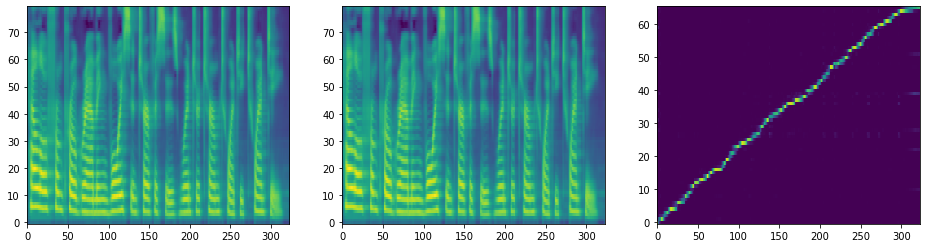

In [14]:
# mel-spectrogram
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

# Further reading 
Check out more deep learning algorithm for speech2text and text2speech at https://github.com/tugstugi/dl-colab-notebooks